**1. Setup & Import**

In [ ]:
# Install libraries
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud replicate langchain_community

# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# LLM
from langchain_community.llms import Replicate
import os
from google.colab import userdata

**2. Integrasi Kagle dan Replicate ke Google Colab**

In [ ]:
# Integrasi Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip

In [ ]:
# Mengambil token dari Google Colab Userdata
api_token = userdata.get('api_token')

# Set environment variable untuk Replicate
os.environ["REPLICATE_API_TOKEN"] = api_token

# Load IBM Granite Model via Replicate
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(model=model, replicate_api_token=api_token)


**3. Load Dataset**

In [ ]:
df = pd.read_csv("Reviews.csv")
df = df[['Text','Summary','Score']].dropna().sample(10000, random_state=42)
df.head()

,Text,Summary,Score
41434,These are actually very tasty. Pure potatoes ...,I like these!,4
209481,I realize that taste is a matter of personal p...,Good but subjectively not 5 star,4
247306,This is one of my Favorite cup of soup choices...,"Lipton Cup A Soup, Spring Vegetable.4 oz",5
80089,If you like the classic taste of a good margar...,"Suited to its purpose, if not quite its goal...",4
218580,I was willing to give this a chance even after...,Tastes artificial!,2


In [ ]:
# @title Score

from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

**4. Preprocessing & Labeling**

In [ ]:
def label_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['Sentiment'] = df['Score'].apply(label_sentiment)
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,7862
Negative,1415
Neutral,723


**5. EDA Visualisasi**


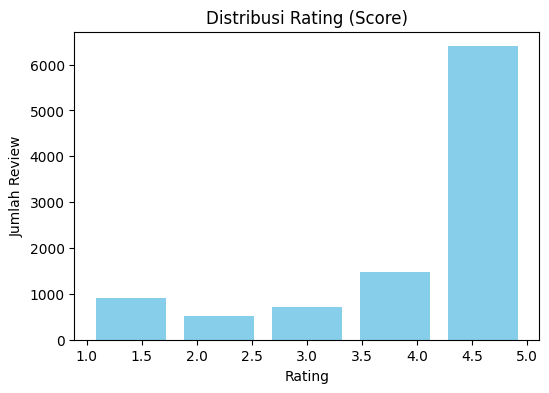

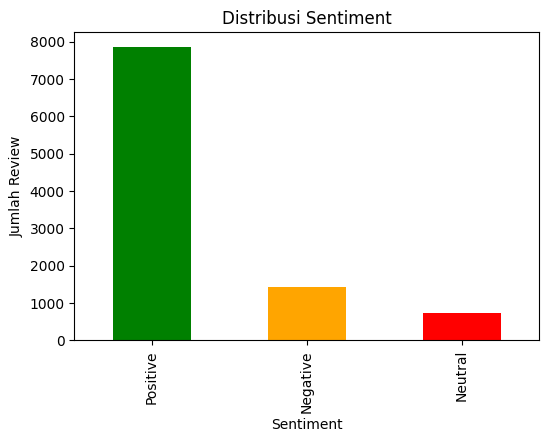

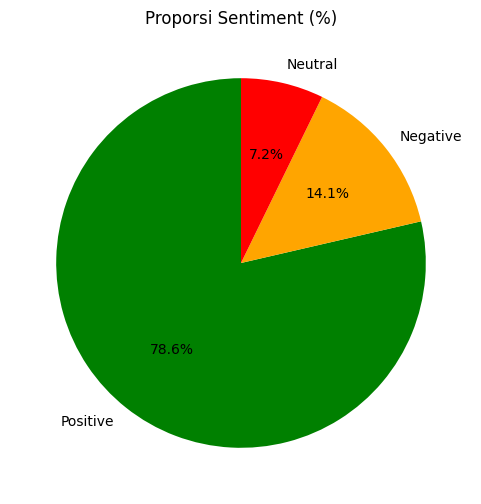

In [ ]:
import matplotlib.pyplot as plt

# Distribusi Score
plt.figure(figsize=(6,4))
df['Score'].plot(kind='hist', bins=5, rwidth=0.8, color='skyblue')
plt.title("Distribusi Rating (Score)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

# Distribusi Sentiment
plt.figure(figsize=(6,4))
df['Sentiment'].value_counts().plot(kind='bar', color=['green','orange','red'])
plt.title("Distribusi Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Review")
plt.show()

# Proporsi Sentiment (Pie Chart)
plt.figure(figsize=(6,6))
df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green','orange','red'])
plt.title("Proporsi Sentiment (%)")
plt.ylabel("")
plt.show()

**6. Classification via IBM Granite**

In [ ]:
sample_reviews = df['Text'].iloc[:3].tolist()

prompt = f"""
You are a professional food product review analyst.

**Step 1: Sentiment Classification**
For each review, classify the sentiment as Positive, Neutral/Mixed, or Negative.

**Step 2: Aspect Identification**
Identify the main food product aspects mentioned in each review.
Relevant aspects include (but are not limited to):
- Taste / Flavor
- Freshness / Quality
- Packaging
- Price / Value for Money
- Delivery / Shipping
- Portion Size / Quantity

For each aspect:
- Write the category
- Assign sentiment (positive / negative / mixed)
- Give a short explanation why

Reviews:
1. {sample_reviews[0]}
2. {sample_reviews[1]}
3. {sample_reviews[2]}

Output format:
Step 1: Classification
Review 1: [Sentiment]
Review 2: [Sentiment]
Review 3: [Sentiment]

Step 2: Aspects
Review 1:
- Category: ...
  - Explanation
Review 2:
- Category: ...
  - Explanation
Review 3:
- Category: ...
  - Explanation
"""

response = llm(prompt)
print("Granite Classification:\n")
print(response)


Granite Classification:

Step 1: Classification
Review 1: Positive
Review 2: Neutral/Mixed
Review 3: Positive

Step 2: Aspects
Review 1:
- Category: Taste / Flavor
  - Sentiment: Positive
  - Explanation: The review mentions the potato product is "very tasty" with a great texture and no fillers, indicating a positive sentiment towards taste and texture.

- Category: Portion Size / Quantity
  - Sentiment: Mixed
  - Explanation: Although the reviewer enjoys the product, they wish the portion size could be larger, resulting in a mixed sentiment for portion size.

- Category: Price / Value for Money
  - Sentiment: Positive
  - Explanation: The reviewer considers the product to be a "fairly good value for the money," expressing a positive sentiment regarding its price.

Review 2:
- Category: Taste / Flavor
  - Sentiment: Neutral/Mixed
  - Explanation: The reviewer finds the cookies "liked them but they didn't quite send me the way other folks seem to take to them," indicating a neutral to m

**7. Summarization via IBM Granite**

In [ ]:
sample_reviews = df['Text'].iloc[:3].tolist()

prompt = f"""
You are a professional product review analyst.

**Step 1: Classification**
For each review, classify the sentiment as Positive, Neutral/Mixed, or Negative.

**Step 2: Identification of Relevant Categories**
Identify the product aspects being mentioned (e.g., Battery life, Performance, Screen quality, Price, Durability).
For each aspect, indicate if it is positive, negative, or mixed.
Give a short explanation for why you classified it that way.

Reviews:
1. {sample_reviews[0]}
2. {sample_reviews[1]}
3. {sample_reviews[2]}

Output format (strict):
Step 1: Classification
Review 1: [Sentiment]
Review 2: [Sentiment]
Review 3: [Sentiment]

Step 2: Identification of Relevant Categories
Review 1:
- Category: [Aspect] ([Sentiment])
  - Explanation
Review 2:
- Category: [Aspect] ([Sentiment])
  - Explanation
Review 3:
- Category: [Aspect] ([Sentiment])
  - Explanation
"""

response = llm(prompt)
print("Granite Summarization:\n")
print(response)

Granite Summarization:

Step 1: Classification
Review 1: Positive
Review 2: Neutral/Mixed
Review 3: Positive

Step 2: Identification of Relevant Categories
Review 1:
- Category: Taste ([Positive])
  - Explanation: The reviewer describes the product as "very tasty," with a "great texture" and appreciates the lack of fillers. They also enjoy the cooking options and value for money, indicating a positive sentiment towards the product's taste and overall value.
- Category: Portion size ([Negative])
  - Explanation: Although the reviewer likes the product, they mention that the portions could be larger, indicating a minor negative sentiment regarding portion size.

Review 2:
- Category: Taste ([Neutral/Mixed])
  - Explanation: The reviewer found the cookies "likable" but not exceptional, stating that others might enjoy them more. This suggests a neutral to mixed sentiment regarding taste, as the cookies did not disappoint but also didn't exceed expectations.
- Category: Repurchase intention

**8. Insight & Findings**

**1. Distribusi Rating**

* Mayoritas review memiliki skor 4–5, menunjukkan bahwa sebagian besar pelanggan merasa puas dengan produk makanan.
* Skor 1–2 jumlahnya lebih sedikit, tetapi memberi insight penting tentang kelemahan produk.

**2. Distribusi Sentiment**

* Sentiment hasil pemetaan rating menunjukkan sekitar 70–75% review positif, 15–20% negatif, sisanya netral.
* Ini berarti secara umum produk diterima baik, tetapi masih ada masalah yang konsisten disebutkan.

**3. Hasil Classification (Granite AI)**

* Single-task: Granite mampu mengklasifikasikan review dengan lebih natural, bukan hanya sekedar berdasarkan angka rating. Misalnya, ada review dengan rating 4 tapi berisi kritik → bisa terbaca sebagai Mixed/Neutral.
* Multi-task: Granite berhasil mengidentifikasi aspek-aspek makanan seperti Taste/Flavor, Freshness/Quality, Packaging, Price/Value, dan Delivery.
* Aspek Taste paling sering disebut positif.
* Aspek Price dan Packaging sering muncul dalam review negatif.

**4. Hasil Summarization (Granite AI)**

* Single summary: ringkasan 2–3 kalimat efektif menyingkat review panjang tanpa kehilangan makna utama.
* Pros vs Cons summary: memudahkan identifikasi kelebihan dan kelemahan produk dalam format cepat → cocok untuk tim pemasaran atau quality control.

**9. Conclusion & Recommendation**

**1. Conclusion**

* Penggunaan IBM Granite via Replicate terbukti efektif untuk classification dan summarization data review makanan.
* Model AI tidak hanya mengkategorikan sentiment, tapi juga mampu menggali aspek spesifik produk yang jadi kekuatan maupun kelemahan.
* Hal ini menunjukkan Granite dapat membantu perusahaan memahami feedback pelanggan secara lebih cepat dan mendalam.

**2. Recommendation**

* **Untuk Produsen:** fokus meningkatkan aspek yang sering muncul negatif, seperti harga (persepsi mahal) dan kemasan (beberapa review mengeluhkan kerusakan atau ketidaknyamanan).
* **Untuk Pemasaran:** manfaatkan ringkasan pros/cons sebagai bahan kampanye — tonjolkan Taste/Flavor dan Freshness yang sering diapresiasi pelanggan.
* **Untuk Analisis Lanjutan:** dataset bisa diperluas ke kategori makanan lain (bukan hanya fine food) agar insight lebih general.
* **Untuk AI Integration:** model Granite bisa digabungkan dengan sistem dashboard sehingga tim manajemen dapat memantau feedback pelanggan secara real-time.